In [13]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys, os

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
from matplotlib.lines import Line2D

me.mechanics_printing()

In [14]:
half = sym.Rational(1,2)
fwt_panels = 10
main_panels = 20
p = RollRig.base_params(panels = (fwt_panels*2 + main_panels))



In [15]:
# Generate Referecne Frame
wing_frame = ma.HomogenousTransform().R_x(sym.pi+p.q[0])
rhs_fwt_frame = wing_frame.Translate(0,p.s_w*half,0).R_x(-p.q[1])  # RHS Fwt Frame
lhs_fwt_frame = wing_frame.Translate(0,-p.s_w*half,0).R_x(-p.q[2])  # LHS Fwt Frame

#Generate Mass Matrices
M_w = ele.MassMatrix(p.m_w)
I_w = ele.MassMatrix(0,I_xx = p.I_xxw)
fwt_w = ele.MassMatrix(p.m_f,I_xx = p.I_xxf)

# Generate Rigid Elements
Wing_point_mass = ele.RigidElement(wing_frame.Translate(0,p.y_w,p.z_w),M_w,gravityPotential=True)
wing_inertia = ele.RigidElement(wing_frame,I_w)
rhs_fwt_mass = ele.RigidElement(rhs_fwt_frame.Translate(0,p.l_f,0),fwt_w,gravityPotential=True)
lhs_fwt_mass = ele.RigidElement(lhs_fwt_frame.Translate(0,-p.l_f,0),fwt_w,gravityPotential=True)

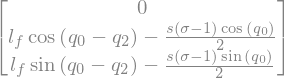

In [16]:
sym.simplify(lhs_fwt_frame.Translate(0,-p.l_f,0).Transform_point((0,0,0)))

In [17]:
# Main Wing Aero Forces 
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_frame.Translate(0,p.y_i,0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = 0,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                               V= p.V,
                               c_d_max = 0,
                               linear = True,
                               z_inverted = True)#.integrate((p.y_w,-p.s_w*half,p.s_w*half))

In [18]:
# split Main Wing into segments
forces = []
for i in range(main_panels):
    seg_width = p.s_w/main_panels
    yi = -p.s_w/2 + seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_i:yi,p.a_0:p.a[fwt_panels+i]})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
wing_AeroForces = ef.ExternalForce(Q)

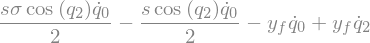

In [19]:
sym.simplify(ef.AeroForce._trigsimp(lhs_fwt_frame.Translate(0,-p.y_f,0).BodyJacobian(p.q)*p.qd))[2]

In [20]:
# Left FWT Aero Forces
lhs_fwt_AeroForces = ef.AeroForce.PerUnitSpan(p,lhs_fwt_frame.Translate(0,-p.y_f,0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = p.alpha_2,
                               alpha_zero = p.alpha_c,
                               stall_angle = 0,
                               c = p.c,
                               V = p.V,
                               c_d_max = 0,
                               linear = True,
                               z_inverted = True)#.integrate((p.y_f,0,p.s_f))

In [21]:
# Left FWT Aero Forces 
rhs_fwt_AeroForces = ef.AeroForce.PerUnitSpan(p,rhs_fwt_frame.Translate(0,p.y_f,0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = p.alpha_1,
                               alpha_zero = p.alpha_c,
                               stall_angle = 0,
                               c = p.c,
                               V = p.V,
                               c_d_max = 0,
                               linear = True,
                               z_inverted = True)#.integrate((p.y_f,0,p.s_f))

In [22]:
# split FTW's into segments
forces = []
for i in range(fwt_panels):
    seg_width = p.s_f/fwt_panels
    yi = seg_width/2 + i*seg_width
    forces.append(lhs_fwt_AeroForces.subs({p.y_f:yi,p.a_0:p.a[fwt_panels-(i+1)]})*seg_width)
    forces.append(rhs_fwt_AeroForces.subs({p.y_f:yi,p.a_0:p.a[fwt_panels+main_panels+i]})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
fwt_AeroForces = ef.ExternalForce(Q)



In [23]:
Forcing = ef.CustomForce(None) 

CompositeForce = ef.CompositeForce([fwt_AeroForces,wing_AeroForces,Forcing])
# create instance of the model
sm = ma.SymbolicModel.FromElementsAndForces(p,[Wing_point_mass,wing_inertia,rhs_fwt_mass,lhs_fwt_mass],ExtForces = CompositeForce)

In [24]:
sm.to_file(p,'RollRigModel.py')

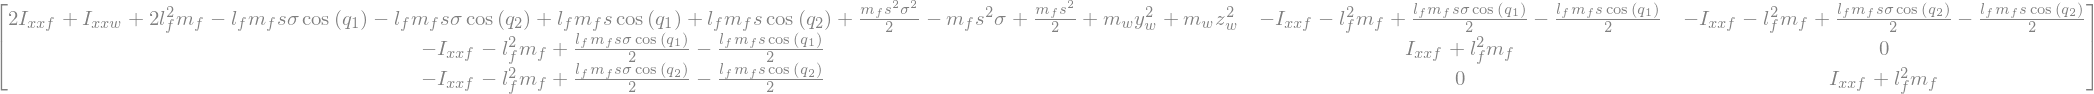

In [174]:
sm.M

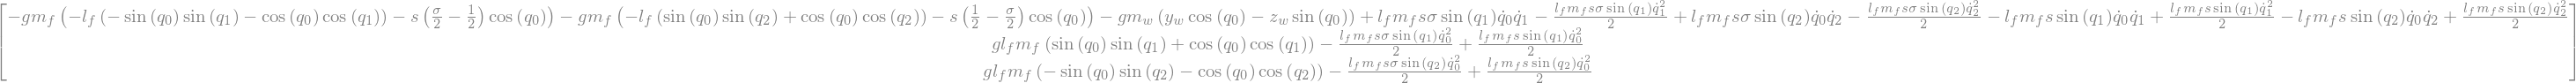

In [175]:
sm.f

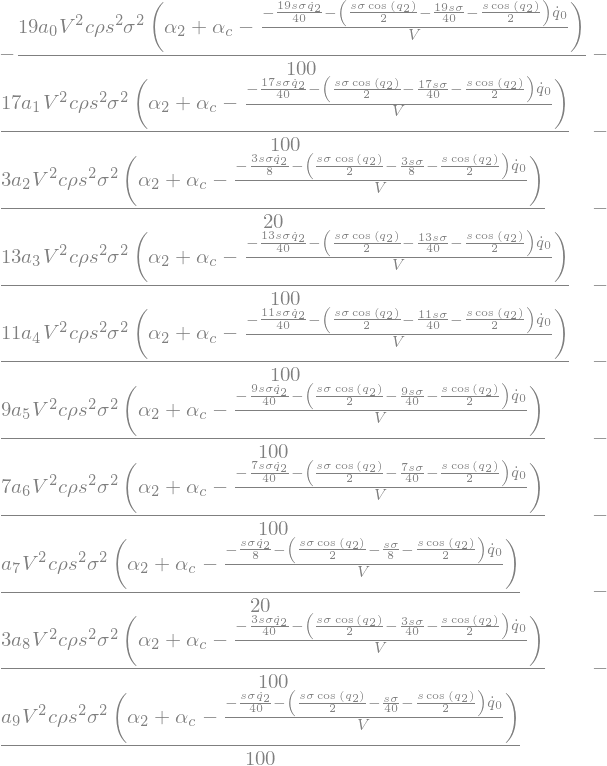

In [176]:
sm.ExtForces.Q()[2]*16